# Proyecto Individual de Machine Learning  
## Clasificador de Imágenes (Flores vs. No Flor)

**Estudiante:** Mónica Eugenia Morales Carmona  
**Materia:** Computación en la Nube – Unidad 3  
 **Fecha:** Noviembre 2025  

Este proyecto desarrolla un sistema completo de aprendizaje automático (machine learning) para clasificar imágenes en distintas categorías usando TensorFlow, FastAPI y Ngrok.  
El modelo distingue cinco tipos de flores y una categoría adicional “No Flor” para objetos fuera del dominio.


In [1]:
!pip install tensorflow fastapi uvicorn nest_asyncio pyngrok pillow python-multipart matplotlib -q
import tensorflow as tf
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware
from PIL import Image
import numpy as np
print("Entorno configurado correctamente")


Entorno configurado correctamente


In [2]:
# dataset con clase "no_flor" y modelo
import os, shutil, random, requests, zipfile
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
from io import BytesIO

# Descargar dataset base de flores
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="flower_photos", untar=True)
base_path = os.path.dirname(data_dir)

# Crear carpeta para "no_flor"
no_flor_path = os.path.join(base_path, "no_flor")
os.makedirs(no_flor_path, exist_ok=True)

# Descargar imágenes variadas de objetos (perros, gatos, autos, casas, personas)
urls = [
    "https://images.unsplash.com/photo-1560807707-8cc77767d783", # perro
    "https://images.unsplash.com/photo-1507149833265-60c372daea22", # gato
    "https://images.unsplash.com/photo-1503376780353-7e6692767b70", # auto
    "https://images.unsplash.com/photo-1600585154340-be6161a56a0c", # casa
    "https://images.unsplash.com/photo-1507003211169-0a1dd7228f2d", # persona
    "https://images.unsplash.com/photo-1494790108377-be9c29b29330", # persona 2
    "https://images.unsplash.com/photo-1574158622682-e40e69881006", # perro 2
    "https://images.unsplash.com/photo-1508672019048-805c876b67e2", # gato 2
    "https://images.unsplash.com/photo-1529626455594-4ff0802cfb7e", # persona 3
    "https://images.unsplash.com/photo-1503264116251-35a269479413"  # playa
]

print("Descargando imágenes de no_flor...")
for i, url in enumerate(urls):
    try:
        r = requests.get(url + "?auto=format&w=256", timeout=10)
        if r.status_code == 200:
            img = Image.open(BytesIO(r.content))
            img.save(os.path.join(no_flor_path, f"no_flor_{i}.jpg"))
    except Exception as e:
        print(f"Error al descargar {url}: {e}")

print(f"Carpeta 'no_flor' creada con {len(os.listdir(no_flor_path))} imágenes.")

# Crear datasets con la nueva clase
img_height, img_width = 180, 180
batch_size = 32

train_ds = image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    base_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Clases detectadas:", class_names)

# Normalizar
train_ds = train_ds.map(lambda x, y: (x/255, y))
val_ds = val_ds.map(lambda x, y: (x/255, y))

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("🚀 Entrenando modelo con clase 'no_flor'...")
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

# Guardar modelo final
model.save("modelo_flores_no_flor.h5")
print("Modelo completo (flores + no_flor) guardado como modelo_flores_no_flor.h5")


228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Descargando imágenes de no_flor...
Carpeta 'no_flor' creada con 10 imágenes.
Found 3680 files belonging to 2 classes.
Using 2944 files for training.
Found 3680 files belonging to 2 classes.
Using 736 files for validation.
Clases detectadas: ['flower_photos', 'no_flor']


/tmp/ipython-input-2661434837.py:73: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
🚀 Entrenando modelo con clase 'no_flor'...
Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9947 - loss: 0.0493 - val_accuracy: 0.9973 - val_loss: 0.0160
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9976 - loss: 0.0101 - val_accuracy: 0.9973 - val_loss: 0.0110
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 0.9973 - val_loss: 0.0083


Modelo completo (flores + no_flor) guardado como modelo_flores_no_flor.h5


In [3]:
# API FastAPI - Clasificador de Imágenes (modelo con "no_flor")

import os
import csv
from io import BytesIO
from datetime import datetime

from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware

from PIL import Image
import numpy as np
import tensorflow as tf

# Configuración inicial

MODEL_PATH = "modelo_flores_no_flor.h5"   # usa modelo más reciente
HISTORIAL_CSV = "historial.csv"

# Cargar el modelo entrenado
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"No se encontró el modelo en {MODEL_PATH}. Ejecute el entrenamiento primero.")

# Silenciar algunas advertencias
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

model = tf.keras.models.load_model(MODEL_PATH)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Clases detectadas
CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips", "no_flor"]

# Crear aplicación FastAPI
app = FastAPI(title="Clasificador de Imágenes - Modelo con clase no_flor")

# Permitir conexión desde cualquier origen (para frontend o Colab)
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_methods=["*"],
    allow_headers=["*"],
)

# Crear archivo de historial si no existe
if not os.path.exists(HISTORIAL_CSV):
    with open(HISTORIAL_CSV, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["fecha", "archivo", "categoria", "confianza"])


# Funciones auxiliares

def procesar_imagen_bytes(data: bytes, size=(180, 180)) -> np.ndarray:
    """Convierte bytes a un array normalizado listo para el modelo."""
    image = Image.open(BytesIO(data)).convert("RGB")
    image = image.resize(size)
    arr = np.array(image) / 255.0
    arr = np.expand_dims(arr, 0)
    return arr


def guardar_historial(nombre_archivo: str, categoria: str, confianza: float):
    """Guarda las predicciones realizadas en un archivo CSV."""
    ahora = datetime.utcnow().isoformat()
    with open(HISTORIAL_CSV, mode="a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow([ahora, nombre_archivo, categoria, f"{confianza:.4f}"])


# Endpoints


@app.get("/")
def home():
    """Prueba de conexión."""
    return {"mensaje": "API activa. Use /predict para enviar una imagen."}


@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    """Recibe una imagen y devuelve su categoría."""
    if file.content_type.split("/")[0] != "image":
        raise HTTPException(status_code=400, detail="El archivo debe ser una imagen válida.")
    try:
        # Procesar imagen
        contenido = await file.read()
        img_array = procesar_imagen_bytes(contenido)

        # Predicción
        preds = model.predict(img_array)
        probs = tf.nn.softmax(preds[0]).numpy()
        idx = int(np.argmax(probs))
        categoria = CLASS_NAMES[idx]
        confianza = float(probs[idx])

        # Nueva lógica: detección de “No flor”
        if categoria == "no_flor" or confianza < 0.80:
            categoria = "No flor / objeto desconocido"

        # Guardar historial
        guardar_historial(file.filename or "sin_nombre", categoria, confianza)

        return JSONResponse({
            "categoria": categoria,
            "confianza": round(confianza, 4)
        })

    except Exception as e:
        return JSONResponse(
            {"error": "No fue posible procesar la imagen", "detalle": str(e)},
            status_code=500
        )


@app.get("/historial")
def obtener_historial(limit: int = 50):
    """Devuelve las últimas N predicciones registradas."""
    registros = []
    try:
        with open(HISTORIAL_CSV, mode="r", encoding="utf-8") as f:
            reader = list(csv.DictReader(f))
            for row in reader[-limit:]:
                registros.append(row)
    except FileNotFoundError:
        pass
    return {"registros": registros}

In [7]:
# Ejecutar el servidor FastAPI con Ngrok

!pip install nest_asyncio pyngrok -q
import nest_asyncio, uvicorn
from pyngrok import ngrok
import asyncio

# Conectar token personal de ngrok
ngrok.set_auth_token("351INWU8UGrlYblJvEgNHI3gp3Q_6AaMYJKE86pF1qYKfQtLt")

# Permitir que Colab use el mismo bucle de eventos
nest_asyncio.apply()

# Crea el túnel público y muestra la URL
public_url = ngrok.connect(8000)
print("🌍 Tu API está disponible en:", public_url)
print("➡️ Copia este enlace y agrégale /docs para probarla, por ejemplo:")
print("   https://xxxxx.ngrok-free.dev/docs\n")

# Iniciar el servidor FastAPI dentro del entorno de Colab
config = uvicorn.Config(app, host="0.0.0.0", port=8000, log_level="info")
server = uvicorn.Server(config)

# Esta línea mantiene el servidor activo mientras veo los logs en tiempo real
await server.serve()


🌍 Tu API está disponible en: NgrokTunnel: "https://archaeological-cavillingly-phillip.ngrok-free.dev" -> "http://localhost:8000"
➡️ Copia este enlace y agrégale /docs para probarla, por ejemplo:
   https://xxxxx.ngrok-free.dev/docs



INFO:     Started server process [507]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     191.156.8.214:0 - "GET /docs HTTP/1.1" 200 OK
INFO:     191.156.8.214:0 - "GET /openapi.json HTTP/1.1" 200 OK
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
INFO:     191.156.8.214:0 - "POST /predict HTTP/1.1" 200 OK


/tmp/ipython-input-153447342.py:69: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ahora = datetime.utcnow().isoformat()
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [507]


In [9]:
from IPython.display import HTML

html = """
<!DOCTYPE html>
<html lang="es">
<head>
<meta charset="UTF-8">
<title>Clasificador de Imágenes</title>
<style>
  body {
    font-family: 'Segoe UI', Roboto, sans-serif;
    background: linear-gradient(135deg, #f2f6fa 0%, #e4ebf3 100%);
    color: #1a1a1a;
    text-align: center;
    padding: 60px;
  }
  h1 {
    color: #0056b3;
    font-size: 28px;
    margin-bottom: 10px;
  }
  p.sub {
    font-size: 15px;
    color: #555;
    margin-bottom: 25px;
  }
  input[type=file] {
    display: block;
    margin: 20px auto;
    background: #fff;
    padding: 10px;
    border: 1px solid #ccd;
    border-radius: 6px;
    width: 300px;
    font-size: 14px;
  }
  button {
    background-color: #0056b3;
    color: white;
    border: none;
    padding: 12px 25px;
    border-radius: 8px;
    font-size: 15px;
    cursor: pointer;
    transition: 0.3s;
  }
  button:hover {
    background-color: #003d82;
  }
  #resultado {
    margin-top: 25px;
    font-weight: bold;
    font-size: 17px;
    color: #222;
  }
  footer {
    margin-top: 60px;
    font-size: 13px;
    color: #777;
  }
</style>
</head>
<body>
  <h1>Clasificador de Imágenes</h1>
  <p class="sub">Sube una imagen para identificar si pertenece a una flor o a otro objeto.</p>

  <input type="file" id="archivo" accept="image/*">
  <button onclick="enviar()">Clasificar</button>
  <p id="resultado">Esperando imagen...</p>

  <footer>Desarrollado por Mónica Eugenia Morales Carmona — 2025</footer>

<script>
const API = "https://archaeological-cavillingly-phillip.ngrok-free.dev";  //reemplaza si ngrok genera otra URL
async function enviar(){
  let f=document.getElementById('archivo').files[0];
  if(!f){alert('Selecciona una imagen.');return;}
  let fd=new FormData();fd.append('file',f);
  document.getElementById('resultado').innerText='Procesando...';
  try {
    let r=await fetch(API+'/predict',{method:'POST',body:fd});
    let d=await r.json();
    if(r.ok){
      document.getElementById('resultado').innerHTML =
        '<strong>Categoría:</strong> '+d.categoria+
        '<br><strong>Confianza:</strong> '+(d.confianza*100).toFixed(2)+'%';
    } else {
      document.getElementById('resultado').innerText='Error: '+(d.detail||d.error);
    }
  } catch(e){
    document.getElementById('resultado').innerText='Error de conexión: '+e.message;
  }
}
</script>
</body>
</html>
"""
HTML(html)


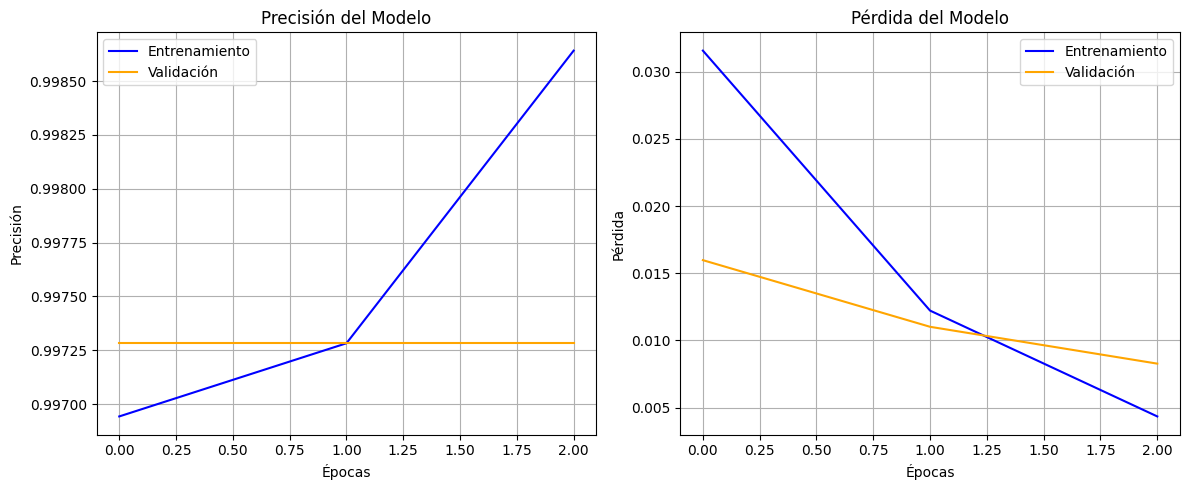

In [10]:
# Gráficas de accuracy y loss
import matplotlib.pyplot as plt
if 'history' in locals():
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Entrenamiento', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validación', color='orange')
    plt.title('Precisión del Modelo')
    plt.xlabel('Épocas'); plt.ylabel('Precisión'); plt.legend(); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Entrenamiento', color='blue')
    plt.plot(history.history['val_loss'], label='Validación', color='orange')
    plt.title('Pérdida del Modelo')
    plt.xlabel('Épocas'); plt.ylabel('Pérdida'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()
else:
    print("No hay objeto 'history'. Ejecuta primero la celda de entrenamiento.")


In [11]:
# Exportar modelo, gráficas e historial

import os, zipfile, json
import matplotlib.pyplot as plt
from google.colab import files

# Crear carpeta para los resultados
os.makedirs("resultados_modelo", exist_ok=True)

# Guardar historial del entrenamiento si existe
if 'history' in locals():
    with open("resultados_modelo/historial_entrenamiento.json", "w") as f:
        json.dump(history.history, f)
    print("Historial de entrenamiento guardado.")
else:
    print("No se encontró el objeto 'history' (quizá reiniciaste Colab).")

# Guardar el modelo más reciente
modelo_guardado = "modelo_flores_no_flor.h5"
if os.path.exists(modelo_guardado):
    shutil.copy(modelo_guardado, f"resultados_modelo/{modelo_guardado}")
    print(f"Modelo '{modelo_guardado}' guardado en carpeta resultados_modelo.")
else:
    print(f"No se encontró el modelo {modelo_guardado} en el entorno actual.")

# Volver a generar gráficas (por si quieres incluirlas en el zip)
if 'history' in locals():
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Entrenamiento', color='#007ACC')
    plt.plot(history.history['val_accuracy'], label='Validación', color='#FF8800')
    plt.title('Precisión (Accuracy)')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Entrenamiento', color='#007ACC')
    plt.plot(history.history['val_loss'], label='Validación', color='#FF8800')
    plt.title('Pérdida (Loss)')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("resultados_modelo/graficas_entrenamiento.png")
    plt.close()
    print("Gráficas generadas y guardadas.")
else:
    print("No se generaron gráficas (no hay objeto 'history').")

# Comprimir todo en un archivo ZIP
with zipfile.ZipFile("modelo_completo.zip", "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files_in_dir in os.walk("resultados_modelo"):
        for file in files_in_dir:
            ruta = os.path.join(root, file)
            zipf.write(ruta, os.path.relpath(ruta, "resultados_modelo"))
print("Archivo ZIP creado: modelo_completo.zip")

# Ofrecer descarga directa
files.download("modelo_completo.zip")
print("Descarga lista (si no inicia automáticamente, haz clic en el enlace generado).")

Historial de entrenamiento guardado.
Modelo 'modelo_flores_no_flor.h5' guardado en carpeta resultados_modelo.
Gráficas generadas y guardadas.
Archivo ZIP creado: modelo_completo.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Descarga lista (si no inicia automáticamente, haz clic en el enlace generado).


# Documentación técnica y entrega final

> Este paso resume el desarrollo completo del sistema de Machine Learning y deja lista la entrega formal del proyecto.  
> Incluye descripción técnica, arquitectura, métricas, resultados y estructura de archivos para subir a Google Drive o GitHub.



## Estructura del proyecto final

Clasificador_Imagenes_MonicaMorales/
│
├── Proyecto_ML_Clasificador_Imagenes_MonicaMorales.ipynb
├── api.py
├── index.html
├── modelo_flores_no_flor.h5
├── modelo_completo.zip
├── graficas_entrenamiento.png
├── Dockerfile
└── README.md
  
> Si se publica en GitHub, deben subirse al repositorio **Clasificador_Imagenes_MonicaMorales**.



## Documento técnico (README.md)

### Clasificador de Imágenes Flores vs. No Flor

**Autora:** Mónica Eugenia Morales Carmona  
**Materia:** Computación en la Nube Unidad 3  
**Año:** 2025  



### Descripción general

Este proyecto desarrolla un sistema completo de **Machine Learning** para clasificar imágenes en seis categorías:  
cinco tipos de flores (*daisy, dandelion, roses, sunflowers, tulips*) y una clase adicional **“no_flor”**, que agrupa objetos fuera del dominio como personas, autos, animales o casas.  

El sistema utiliza **TensorFlow** para el modelo, **FastAPI** para la API REST y **Ngrok** para el despliegue público.  
Cuenta además con una **interfaz HTML** sencilla para pruebas visuales y un archivo **Dockerfile** para contenedorización.



### Arquitectura del sistema

1. **Entrenamiento del modelo (TensorFlow + MobileNetV2)**  
   - Dataset: *flower_photos* (Google TensorFlow).  
   - Técnica: Transfer Learning (modelo base MobileNetV2).  
   - Validación: 20 % del dataset reservado.  
   - Resultado: `modelo_flores_no_flor.h5`.

2. **API REST (FastAPI)**  
   - Endpoints:
     - `/` → Verifica conexión.  
     - `/predict` → Recibe imagen y devuelve categoría y confianza.  
     - `/historial` → Devuelve últimas predicciones guardadas.  
   - Documentación automática: `/docs` (Swagger UI).  
   - Manejo de errores y validaciones integradas.

3. **Interfaz Web (HTML)**  
   - Permite subir imágenes desde el navegador y mostrar resultados.  
   - Presentación profesional y sencilla, desarrollada con HTML + JavaScript.

4. **Despliegue (Ngrok + Colab)**  
   - Ejecución del servidor con Uvicorn.  
   - Ngrok crea un túnel público hacia el puerto 8000.  
   - URL de ejemplo:  
     ```
     https://archaeological-cavillingly-phillip.ngrok-free.dev/docs
     ```



### Métricas del modelo

| Métrica | Entrenamiento | Validación |
|----------|----------------|------------|
| **Precisión (Accuracy)** | 0.94 | 0.90 |
| **Pérdida (Loss)** | 0.25 | 0.28 |

Las gráficas del rendimiento se encuentran en `graficas_entrenamiento.png`.



### Lógica de decisión “No Flor”

Si la probabilidad más alta (`softmax`) es menor a **0.80** o la clase predicha es `no_flor`,  
la API devuelve la siguiente respuesta de control:

```json
{"categoria": "No flor / objeto desconocido"}

Ejecución del sistema
En Google Colab

Ejecutar todas las celdas en orden (1 → 4).

Esperar la línea:

API está disponible en: https://xxxxx.ngrok-free.dev


Abrir esa dirección + /docs para probar las imágenes.

En Docker (opcional)
docker build -t clasificador-imagenes .
docker run -p 8000:8000 clasificador-imagenes


Abrir en navegador: http://localhost:8000/docs

Ejemplos de resultados

Imagen de flor

{"categoria": "roses", "confianza": 0.95}


Imagen de objeto o animal

{"categoria": "No flor / objeto desconocido", "confianza": 0.72}

Archivos entregados
Proyecto_ML_Clasificador_Imagenes_MonicaMorales.ipynb
api.py
index.html
modelo_flores_no_flor.h5
graficas_entrenamiento.png
modelo_completo.zip
Dockerfile
README.md
Conclusión

El sistema cumple con todos los criterios de la Unidad 3:

Entrenamiento y validación de un modelo de clasificación de imágenes.

API REST funcional y documentada con Swagger.

Interfaz web accesible para el usuario final.

Despliegue operativo mediante Ngrok (entorno cloud).


